In [44]:
import numpy as np
import csv
import igl
import math
import ripleyK as rk
import ripleyKtest as rkt
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
from scipy.io import loadmat 
import os
import geopandas as gpd
import plotly.graph_objects as go

In [45]:
def readmitodata(fname):
    """
    Expect a filename of the form "mito_data???.mat" 
    where ??? is the mito number (left padded by 0 is necessary).
    
    argument:
    fname -- string, filename of the mito data
    
    returns:
    mito_dict -- dictionary, keys are the names of the variables in the matlab file
    The keys are:
    'mito' -- the mitochondrion binary shaoe (np.ndarray, has been padded with zeros)
    'vertices' -- the vertices of the meshed mitochondrion (np.ndarray)  
    'faces' -- the faces of the meshed mitochondrion (np.ndarray)
    'cristae_junctions' -- the vertices of the cristae junctions (np.ndarray) or empty list if none
    'min_coords' -- the minimum coordinates of the mitochondrion (np.ndarray) in the original volume    
    'mito_number' -- the number of the mitochondrion (int) from the cc3d.component_labeling function,
                        this is the same as the number in the filename
    
    """
    mito_dict = loadmat(fname)
    # remove matlab meta data
    del mito_dict['__header__']
    del mito_dict['__version__']
    del mito_dict['__globals__']
    mito_dict['mito_number'] = int(mito_dict['mito_number'])
    # inverted results in matlab....
    mito_dict['vertices'], mito_dict['faces'] = mito_dict['faces'], mito_dict['vertices']
    # count starts at 0
    mito_dict['faces'] -= 1
    return mito_dict

In [46]:
current_dir = os.getcwd()
folder_path = os.path.join(current_dir, "mito_data")
path = os.path.join(folder_path, "mito_data002.mat")
mito = readmitodata(path)  

In [47]:
print(mito.keys())
vertices = np.array(mito['vertices'], dtype=np.float64)
faces = np.array(mito['faces'], dtype=np.int32)
cj = np.array(mito['cristae_junction'], dtype=np.float64)

points = cj.T
print(cj.shape)
print(vertices.shape)
print(faces.shape)

print(vertices.min(), vertices.max())
print(faces.min(), faces.max())

dict_keys(['cristae_junction', 'faces', 'min_coords', 'mito', 'mito_number', 'vertices'])
(3, 6)
(5990, 3)
(11976, 3)
1.505 44.495
0 5989


In [48]:
#Projecting the point on the mesh
def project_point_to_mesh(point, vecs):
    u = vecs[1] - vecs[0]
    v = vecs[2] - vecs[0]
    n = np.cross(u, v)
    w = point - vecs[0]

    gamma = np.dot(np.cross(u, w), n) / np.dot(n, n)
    beta = np.dot(np.cross(w, v), n) / np.dot(n, n)
    alpha = 1 - gamma - beta

    y = alpha * vecs[0] + beta * vecs[1] + gamma * vecs[2]
    return y

In [49]:
# Calculating the shortest path between two points on the mesh
def shortest_path(vecs, faces, vs, vt, svec ,tvec):

    shortest_path = math.inf

    # # get the indices and coordinates of the closest vertices to the source and target points
    # ds = igl.point_mesh_squared_distance(vs, vecs, faces)
    # # ds = igl.signed_distance(vs, vecs, faces)
    # svec = faces[ds[1]]
    svec_coords = vecs[svec] # coordinate for the 3 closest vertices to the source
    
    # dt = igl.point_mesh_squared_distance(vt, vecs, faces)
    # #dt = igl.signed_distance(vt, vecs, faces)
    # tvec = faces[dt[1]]
    tvec_coords = vecs[tvec] # coordinate for the 3 closest vertices to the target

    # find the shortest path between the source and target points
    vs = project_point_to_mesh(vs, svec_coords).astype(float) # project the source point on the mesh
    # vs = projToMesh(vs, svec_coords).astype(float)
    dist_vs_vecs = np.linalg.norm(vs-svec_coords, axis=1) # distance between the source point and the closest vertices
    # print(dist_vs_vecs)
    vt = project_point_to_mesh(vt, tvec_coords).astype(float) # project the target point on the mesh
    # vt = projToMesh(vt, tvec_coords).astype(float)
    dist_vt_vecs = np.linalg.norm(vt-tvec_coords, axis=1) # distance between the target point and the closest vertices
    # print(dist_vt_vecs)
    dist_vecs = igl.exact_geodesic(vecs, faces, svec, tvec) # distance between the closest vertices
    dist = dist_vs_vecs + dist_vecs + dist_vt_vecs # total distance
    shortest_path = np.min(dist)
    
    return shortest_path

# Calculating the distance between all pairs of points on the mesh
def pair_distance_mesh(vecs, faces, samples):
    npts = np.shape(samples)[0]
    dist = []
    point_mesh = igl.point_mesh_squared_distance(samples, vecs, faces)
    for i in range(npts):
        for j in range(i+1, npts):
            # reshape to (1,3) array
            vs = samples[i].reshape(1,3)
            vt = samples[j].reshape(1,3)
            svec = faces[point_mesh[1][i]]
            tvec = faces[point_mesh[1][j]]
            d = shortest_path(vecs, faces, vs, vt, svec, tvec)
            dist.append(d)
    return dist

In [50]:
dist1 = pair_distance_mesh(vertices, faces, points)
print(dist1)
dist2 = rk.pair_distance_mesh(vertices, faces, points)
print(dist2)

[13.224323289356095, 7.619811514039917, 16.69030628266761, 19.413198037878267, 30.143048100812173, 18.63702237606158, 14.869775998297785, 15.036191052804428, 31.019748639112898, 14.584770635155925, 15.0120874774041, 27.011036668732302, 2.932354335638438, 17.4048281823385, 18.54408908738603]
[13.224323289356095, 7.619811514039914, 16.69030628266761, 19.413198037878264, 30.143048100812194, 18.637022376061577, 14.869775998297785, 15.036191052804424, 31.01974863911292, 14.584770635155923, 15.012087477404094, 27.01103666873232, 2.932354335638435, 17.40482818233852, 18.544089087386048]


In [40]:
# points = cj.T

# x, y, z = vertices.T
# i, j, k = faces.T

# mesh = go.Mesh3d(x=x, y=y, z=z, i=i, j=j, k=k, color='lightpink', opacity=0.50)
# fig = go.Figure(data=[mesh])
# fig.add_trace(go.Scatter3d(x=points[:,0], y=points[:,1], z=points[:,2], mode='markers', marker=dict(size=10, color='blue')))
# fig.show()

In [41]:
#  Computes signed distance to a mesh

#  Inputs:
#    P  #P by 3 list of query point positions
#    V  #V by 3 list of vertex positions
#    F  #F by ss list of triangle indices, ss should be 3 unless sign_type ==
#      SIGNED_DISTANCE_TYPE_UNSIGNED
#    sign_type  method for computing distance _sign_ S
#    lower_bound  lower bound of distances needed {std::numeric_limits::min}
#    upper_bound  lower bound of distances needed {std::numeric_limits::max}
#  Outputs:
#    S  #P list of smallest signed distances
#    I  #P list of facet indices corresponding to smallest distances
#    C  #P by 3 list of closest points
#    N  #P by 3 list of closest normals (only set if
#      sign_type=SIGNED_DISTANCE_TYPE_PSEUDONORMAL)

# if points != []:
    # signed_dist = igl.signed_distance(points, vertices, faces)
    # print(signed_dist)

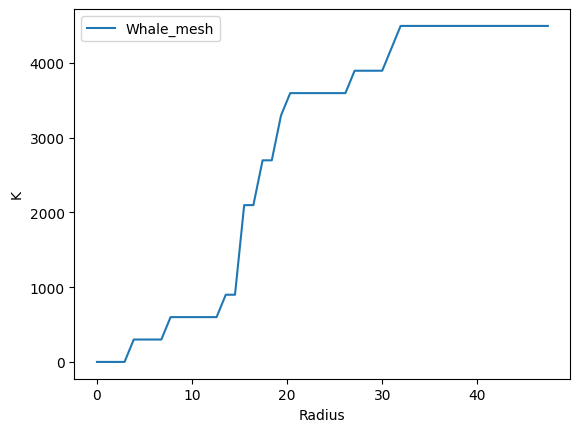

In [43]:
rmax = math.sqrt(rk.mesh_area(vertices, faces) / 2)
radii = np.linspace(0, rmax, 50)

if cj.size:
    kt_mito = rk.ripleyK_mesh(vertices, faces, points, radii)
    # kt_mito = rkt.ripleyK_mesh(vertices, faces, points, radii)
    data = np.column_stack((radii, kt_mito))
    np.savetxt("kt_mito.csv", data, delimiter=",", header='radii,kt_mito')
else:
    print("No cristae junctions found")

plt.plot(radii, kt_mito, label='Whale_mesh')
plt.xlabel('Radius')
plt.ylabel('K')
plt.legend()
plt.show()



In [ ]:
current_dir = os.getcwd()
data_dir = os.path.join(current_dir, "mito_data")
result_dir = os.path.join(current_dir, "mito_result")

for file_name in os.listdir(data_dir):
    if file_name.endswith(".mat"):
        file_path = os.path.join(data_dir, file_name)
        mito = readmitodata(file_path)
        vertices = np.array(mito['vertices'], dtype=np.float64)
        faces = np.array(mito['faces'], dtype=np.int32)
        cj = np.array(mito['cristae_junction'], dtype=np.float64)
        points = cj.T
        rmax = math.sqrt(rk.mesh_area(vertices, faces) / 2)
        radii = np.linspace(0, rmax, 50)
        if cj.size:
            print(file_name)
            kt_mito = rk.ripleyK_mesh(vertices, faces, points, radii)
            data = np.column_stack((radii, kt_mito))
            result_path = os.path.join(result_dir, os.path.splitext(file_name)[0] + ".csv")
            np.savetxt(result_path, data, delimiter=",", header='radii,kt_mito')
            print(file_name + " result saved")
        else:
            print("No cristae junctions found")

No cristae junctions found
mito_data283.mat
mito_data283.mat result saved
No cristae junctions found
No cristae junctions found
mito_data064.mat
mito_data064.mat result saved
mito_data464.mat
